<a href="https://colab.research.google.com/github/serg-kas/NN-archive/blob/main/%D0%90%D0%BF%D1%80%D0%B5%D0%BB%D1%8C%D1%81%D0%BA%D0%B8%D0%B9_%D0%BA%D1%83%D1%80%D1%81_2020_Light_%D0%94%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_21_%D0%9F%D1%80%D1%8F%D0%BC%D1%8B%D0%B5_%D0%B8_%D1%81%D0%B2%D1%91%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%B4%D0%BB%D1%8F_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D0%B0%D1%83%D0%B4%D0%B8%D0%BE%D1%81%D0%B8%D0%B3%D0%BD%D0%B0%D0%BB%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Light задание. 

**Вариант 1**

Использую шаблон ноутбука, напишите загрузку данных и распознавание стилей музыки с помощью Dense сети. Можно подсматривать в исходный ноутбук с занятия, но желательно писать код своими руками



In [ ]:
#Подключаем библиотеки

import numpy as np #Numpy массивы

import librosa #Параметризация аудио

from tensorflow.keras import utils #Для to_categorical
from tensorflow.keras.optimizers import Adam, RMSprop #Оптимизаторы
from tensorflow.keras.models import Sequential, Model #Два формата модели keras
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, MaxPooling2D, LSTM #Базовые слои

from sklearn.model_selection import train_test_split #Разбиение на обучающую и проверочную выборку
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler #Для нормировки данных

import matplotlib.pyplot as plt #Отображение графиков
#Отрисовка графиков в ячейках collab
%matplotlib inline

from google.colab import files #Загрузка файлов
import os #Работа с папками и файлами
import zipfile #Для разархивации базы

import time #Для подсчёта времени на обработку одного жанра

#Отключаем предупреждения
#import warnings
#warnings.filterwarnings('ignore')

In [ ]:
#Подключаем Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Разархивируем архив с базой
z = zipfile.ZipFile('/content/drive/My Drive/my_sample_data/Д.З.21/genres.zip', 'r')
z.extractall()

#Задаём названия жанров
#В архиве названия папок совпадают с названиями жанров
genres = 'blues classical country disco hiphop jazz metal pop reggae rock'.split()
print('Список жанров', genres)

#Проверяем выгруженные папки
!ls genres 
#!ls genres/blues

Список жанров ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
blues  classical  country  disco  hiphop  jazz	metal  pop  reggae  rock


In [ ]:
#Функция параметризации аудио
def get_features(y, sr):
  #Получаем различные параметры аудио
  chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr)) #Частота цветности
  #chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) 
  rmse = np.mean(librosa.feature.rmse(y=y)) #Среднеквадратичная амплитуда
  spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #Спектральный центроид
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #Спектральная ширина
  rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Спектральный спад частоты
  zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #Пересечения нуля
  mfcc = librosa.feature.mfcc(y=y, sr=sr) #Мел кепстральные коэффициенты
  
  #Добавляем все параметры в один список
  out = []
  out.append(chroma_stft)
  out.append(rmse)
  out.append(spec_cent)
  out.append(spec_bw)
  out.append(rolloff)
  out.append(zcr)
  
  #По одному добавляем все Мел коэффициенты
  for e in mfcc:
    out.append(np.mean(e))

  #добавляем среднее всех Частот цветности (12 значений)
  #for e in chroma_stft:
  #  out.append(np.mean(e))
  
  
  #Возвращаем получившийся список
  return out

In [ ]:
#Формируем обучающую выборку

#Создаём пустые листы
X_train = []
Y_train = []

#Запоминаем время старта формирования выборки
curr_time = time.time()

#Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  print('Готовим ', g)
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    #Используем первые 30 секунд аудио
    y, sr = librosa.load(songname, mono=True, duration=30)
    #Превращаем сигнал в параметризованные данные
    out = get_features(y, sr)
    
    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(utils.to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Готовим  blues
Жанр blues готов -> 116c
Готовим  classical
Жанр classical готов -> 117c
Готовим  country
Жанр country готов -> 117c
Готовим  disco
Жанр disco готов -> 117c
Готовим  hiphop
Жанр hiphop готов -> 116c
Готовим  jazz
Жанр jazz готов -> 116c
Готовим  metal
Жанр metal готов -> 116c
Готовим  pop
Жанр pop готов -> 116c
Готовим  reggae
Жанр reggae готов -> 117c
Готовим  rock
Жанр rock готов -> 116c


In [ ]:
#Перейдем от ohe к нумерованной катергории Y_train
y_train_class = np.argmax(Y_train, axis=1)
#print(y_train_class)

In [ ]:
#Выводим размеры выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 26)
(1000, 10)
(1000,)


In [ ]:
#сохраним готовые массивы
#np.save('/content/drive/My Drive/my_sample_data/Д.З.21/X_train1', X_train)
#np.save('/content/drive/My Drive/my_sample_data/Д.З.21/Y_train1', Y_train)
#np.save('/content/drive/My Drive/my_sample_data/Д.З.21/y_train_class1', y_train_class)

In [ ]:
#СКАЧАТЬ ГОТОВЫЕ ДАННЫЕ МОЖНО ТУТ
X_train = np.load('/content/drive/My Drive/my_sample_data/Д.З.21/X_train1.npy')
Y_train = np.load('/content/drive/My Drive/my_sample_data/Д.З.21/Y_train1.npy')
y_train_class = np.load('/content/drive/My Drive/my_sample_data/Д.З.21/y_train_class1.npy')

print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']


(1000, 26)
(1000, 10)
(1000,)


In [ ]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#scaler = MinMaxScaler() 
#Номируем X_train
X_train = scaler.fit_transform(X_train)

In [ ]:
#Проверяем, что X_train нормировался
print(X_train[0])

[-1.06268812 -0.21870783  0.23653476 -0.06246315  0.27472304  0.51427612
  0.23027605 -0.11004258 -0.49304669  0.70345379 -3.08208182  0.85447998
 -2.79811788 -0.19318686 -1.30463353 -0.20428536 -2.04903546  0.34584874
 -2.35684907 -0.37866986 -1.72007026 -1.32743392 -1.41636317 -0.66117584
  0.14933772 -0.74753698]


In [ ]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 26)
(900,)
(100, 26)
(100,)


Epoch 1/200
45/45 [==============================] - 0s 7ms/step - loss: 2.1257 - accuracy: 0.2389 - val_loss: 1.7981 - val_accuracy: 0.3700
Epoch 2/200
45/45 [==============================] - 0s 4ms/step - loss: 1.8011 - accuracy: 0.3722 - val_loss: 1.5789 - val_accuracy: 0.4400
Epoch 3/200
45/45 [==============================] - 0s 4ms/step - loss: 1.6520 - accuracy: 0.3878 - val_loss: 1.4639 - val_accuracy: 0.4800
Epoch 4/200
45/45 [==============================] - 0s 4ms/step - loss: 1.5557 - accuracy: 0.4278 - val_loss: 1.3864 - val_accuracy: 0.4900
Epoch 5/200
45/45 [==============================] - 0s 4ms/step - loss: 1.4809 - accuracy: 0.4700 - val_loss: 1.3249 - val_accuracy: 0.5600
Epoch 6/200
45/45 [==============================] - 0s 4ms/step - loss: 1.4220 - accuracy: 0.4911 - val_loss: 1.2759 - val_accuracy: 0.5600
Epoch 7/200
45/45 [==============================] - 0s 4ms/step - loss: 1.3687 - accuracy: 0.5189 - val_loss: 1.2429 - val_accuracy: 0.5800
Epoch 8/200
4

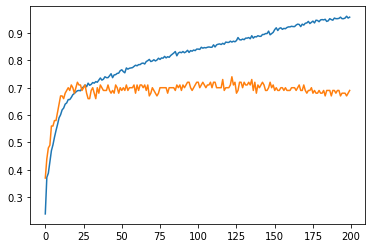

In [ ]:

#Создаём полносвязанную сеть 
model = Sequential()
model.add(Dense(256, activation='elu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='elu'))
model.add(Dense(64, activation='elu'))
model.add(Dense(32, activation='elu'))
#В конце количество нейронов равно количеству классов и softmax
model.add(Dense(len(genres), activation='softmax'))

#Компилируем сеть
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=20,
                    validation_data=(X_test, y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

**Загрузку данных, подготовку данных и обучение полносвязной модели  по шаблону ноутбука восстановили. Далее будем добиваться точности 79% (задание Pro1)**

##PRO задание.

**Вариант 1**

Добейтесь точности распознавания жанров музыки не менее 79% стабильно на последних эпохах обучения. Используйте разбивку 900 записей на обучающую выборку и 100 на проверочную


In [ ]:
#Дополняем полносвязанную сеть 
model2 = Sequential()
model2.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(BatchNormalization())
model2.add(Dense(32, activation='relu'))
#В конце количество нейронов равно количеству классов и softmax
model2.add(Dense(len(genres), activation='softmax'))


Epoch 1/10
45/45 [==============================] - 0s 8ms/step - loss: 0.5120 - accuracy: 0.8356 - val_loss: 0.9633 - val_accuracy: 0.7900
Epoch 2/10
45/45 [==============================] - 0s 4ms/step - loss: 0.4685 - accuracy: 0.8444 - val_loss: 0.9682 - val_accuracy: 0.7900
Epoch 3/10
45/45 [==============================] - 0s 5ms/step - loss: 0.5490 - accuracy: 0.8122 - val_loss: 0.9685 - val_accuracy: 0.7900
Epoch 4/10
45/45 [==============================] - 0s 5ms/step - loss: 0.5260 - accuracy: 0.8167 - val_loss: 0.9627 - val_accuracy: 0.7800
Epoch 5/10
45/45 [==============================] - 0s 4ms/step - loss: 0.5393 - accuracy: 0.8156 - val_loss: 0.9611 - val_accuracy: 0.7900
Epoch 6/10
45/45 [==============================] - 0s 4ms/step - loss: 0.5758 - accuracy: 0.8178 - val_loss: 0.9677 - val_accuracy: 0.7900
Epoch 7/10
45/45 [==============================] - 0s 4ms/step - loss: 0.5186 - accuracy: 0.8156 - val_loss: 0.9703 - val_accuracy: 0.7900
Epoch 8/10
45/45 [==

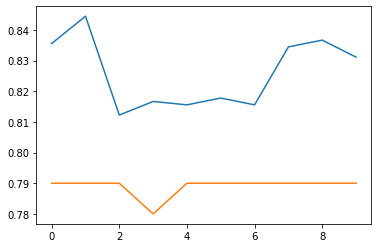

In [ ]:
#Компилируем сеть
model2.compile(optimizer=RMSprop(lr=5e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model2.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=20,
                    validation_data=(X_test, y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
#Сохранение и загрузка весов
#model2.save_weights('/content/drive/My Drive/my_sample_data/Д.З.21/model2_weights.h5')
model2.load_weights('/content/drive/My Drive/my_sample_data/Д.З.21/model2_weights.h5')

**Модель немного подправили. Добавили слои dropout и batchnormalization. Сохранены веса, выводящие на точность 0.79**

##PRO задание.

**Вариант 2**

Запустите сеть не на усреднённых данных, а на полных данных всех коэффициентов, развёрнутых по частотам - одномерные и двумерные вектора. Для классификации используйте не полную длину спектра по файлу (30 секунд), а отдельные участки равной длины (например, по 5 секунд). При классификации итогового файла классифицируйте его по сумме классов всех его участков. Аналогично мы делали при распознавании писателей Можно использовать слои Conv1D, LSTM и Conv2D (Dense, Dropout и остальные)

**Делаю не совсем по заданию Pro2. Попробую такую гипотезу:**

 1.~~Увеличим количество отсчетов MFCC до 40.~~

 2.Будем резать файл на участки по 500 сэмплов = 23 мс. Всего 1320 фрагментов на файл.

 3.Прочие параметры (кроме MFCC) пока уберем. 

**Обработанные данные будут представлять из себя как-бы набор картинок размером 1320х20, которые будем подавать на сверточные слои.**


In [ ]:
#Функция параметризации аудио
def get_features_2(y, sr):

  # Различные параметры аудио
  #chroma_stft = np.mean(librosa.feature.chroma_stft(y=y, sr=sr)) #Частота цветности
  #rmse = np.mean(librosa.feature.rmse(y=y)) #Среднеквадратичная амплитуда
  #spec_cent = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr)) #Спектральный центроид
  #spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=y, sr=sr)) #Спектральная ширина
  #rolloff = np.mean(librosa.feature.spectral_rolloff(y=y, sr=sr)) #Спектральный спад частоты
  #zcr = np.mean(librosa.feature.zero_crossing_rate(y)) #Пересечения нуля
  mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)  #Мел кепстральные коэффициенты на фрагменте
  #print(mfcc.shape)
 
  #Добавляем все параметры в один список
  out = []
  #out.append(chroma_stft)
  #out.append(rmse)
  #out.append(spec_cent)
  #out.append(spec_bw)
  #out.append(rolloff)
  #out.append(zcr)
  
  #На коротком участке в 500 сэмплов отсчет MFCC будет 1
  #Если отсчет будет не один, то выводим среднее (оставил для на всяк.случай)
  for e in mfcc:
    if (e.shape[0] == 1):
       out.append(e[0])
    else:
       out.append(np.mean(e))

  #Возвращаем получившийся список
  return out

In [ ]:
# Формируем обучающую выборку
  
# Звуковые файлы ок.30сек будем делить на фрагменты
# примерно по 23мс (всего 660000 сэмплов)
S = 500    #сэмплов во фрагменте
N = 1320    #фрагментов

# Создаём пустые листы
X_train = []
Y_train = []

# Запоминаем время старта формирования выборки
curr_time = time.time()

# Проходим по всем жарнам
for i in range(len(genres)):
  g = genres[i] #Берём текущий жанр
  print('Готовим ', g)
  #Проходим по файлам папки, соответствующей текущему жанру
  for filename in os.listdir(f'./genres/{g}'):
    #Получаем имя песни
    songname = f'./genres/{g}/{filename}'
    #Загружаем в y аудиосигнал
    y, sr = librosa.load(songname, mono=True, duration=30)
    
    #Превращаем сигнал в параметризованные данные
    #цикл по N фрагментам длиной S семплов
    out = []
    for nn in range(N):
      #out.append(get_features_2(y[S*nn : S*(nn+1)], sr))  #так получается список из 1320 списков по 20 элементов 
      out = out + get_features_2(y[S*nn : S*(nn+1)], sr)   #так получается список из 26400 элементов
    
    #Старый вызов функции
    #out = get_features_2(y, sr)

    #Добавляем строку в X_train
    X_train.append(out)
    #Добавляем в Y_train номер жанра в формате ohe
    Y_train.append(utils.to_categorical(i, len(genres)))

  #Выводим информацию о готовности обработки базы
  print("Жанр ", g, " готов -> ", round(time.time() - curr_time), "c", sep="")
  curr_time = time.time()

#Превращаем обучающую выборку на numpy массивы
X_train = np.array(X_train)
Y_train = np.array(Y_train)

Готовим  blues
Жанр blues готов -> 640c
Готовим  classical
Жанр classical готов -> 639c
Готовим  country
Жанр country готов -> 646c
Готовим  disco
Жанр disco готов -> 646c
Готовим  hiphop
Жанр hiphop готов -> 635c
Готовим  jazz
Жанр jazz готов -> 640c
Готовим  metal
Жанр metal готов -> 639c
Готовим  pop
Жанр pop готов -> 644c
Готовим  reggae
Жанр reggae готов -> 646c
Готовим  rock
Жанр rock готов -> 655c


In [ ]:
#Перейдем от ohe к нумерованной катергории Y_train
y_train_class = np.argmax(Y_train, axis=1)
#print(y_train_class)

In [ ]:
#Выводим размеры выборки
print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

(1000, 26400)
(1000, 10)
(1000,)


In [ ]:
#сохраним готовые массивы этого варианта
#np.save('/content/drive/My Drive/my_sample_data/Д.З.21/X_train_Pro2', X_train)
#np.save('/content/drive/My Drive/my_sample_data/Д.З.21/Y_train_Pro2', Y_train)
#np.save('/content/drive/My Drive/my_sample_data/Д.З.21/y_train_Pro2', y_train_class)

In [ ]:
#СКАЧАТЬ ГОТОВЫЕ ДАННЫЕ МОЖНО ТУТ
X_train = np.load('/content/drive/My Drive/my_sample_data/Д.З.21/X_train_Pro2.npy')
Y_train = np.load('/content/drive/My Drive/my_sample_data/Д.З.21/Y_train_Pro2.npy')
y_train_class = np.load('/content/drive/My Drive/my_sample_data/Д.З.21/y_train_Pro2.npy')

print(X_train.shape)
print(Y_train.shape)
print(y_train_class.shape)

genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']

(1000, 26400)
(1000, 10)
(1000,)


In [ ]:
#Создаём scaler экземпляр класса StandardScaler() для нормировки данных
scaler = StandardScaler()
#Номируем X_train
X_train = scaler.fit_transform(X_train)

In [ ]:
#Проверяем, что X_train нормировался
print(X_train[0])

[-0.30107179  0.01552097 -0.27099687 ... -0.03498228  0.62833587
 -0.21535672]


In [ ]:
#Разделяем выборку на обучающую и проверочную
#Для проверочной используем 10% примеров
#Так как база маленькая
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train_class, test_size=0.1)

In [ ]:
#Выводим размеры обучающей и проверочной выборки для проверки
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(900, 26400)
(900,)
(100, 26400)
(100,)


**Нейронная сеть с Conv2D**

In [ ]:
X_train = X_train.reshape(900, 1320, 20, 1)
X_test = X_test.reshape(100, 1320, 20, 1)

print(X_train.shape)
print(X_test.shape)

(900, 1320, 20, 1)
(100, 1320, 20, 1)


In [ ]:
model_p3 = Sequential()

model_p3.add(Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(1320, 20, 1)))

model_p3.add(BatchNormalization())

model_p3.add(Conv2D(128, (3, 3), padding='same', activation='relu'))

model_p3.add(BatchNormalization())

model_p3.add(MaxPooling2D(pool_size=(2, 2)))

model_p3.add(Dropout(0.3))

model_p3.add(Flatten())

model_p3.add(Dense(128, activation='relu'))
model_p3.add(Dropout(0.3))
model_p3.add(BatchNormalization())
model_p3.add(Dense(32, activation='relu'))
model_p3.add(Dropout(0.3))
model_p3.add(BatchNormalization())

#В конце количество нейронов равно количеству классов и softmax
model_p3.add(Dense(len(genres), activation='softmax'))

Epoch 1/5
45/45 [==============================] - 20s 437ms/step - loss: 0.3239 - accuracy: 0.9478 - val_loss: 1.0317 - val_accuracy: 0.6900
Epoch 2/5
45/45 [==============================] - 19s 433ms/step - loss: 0.3461 - accuracy: 0.9456 - val_loss: 1.0275 - val_accuracy: 0.6800
Epoch 3/5
45/45 [==============================] - 19s 433ms/step - loss: 0.3134 - accuracy: 0.9622 - val_loss: 1.0294 - val_accuracy: 0.6800
Epoch 4/5
45/45 [==============================] - 19s 433ms/step - loss: 0.3219 - accuracy: 0.9567 - val_loss: 1.0258 - val_accuracy: 0.6800
Epoch 5/5
45/45 [==============================] - 19s 433ms/step - loss: 0.3323 - accuracy: 0.9611 - val_loss: 1.0249 - val_accuracy: 0.6900


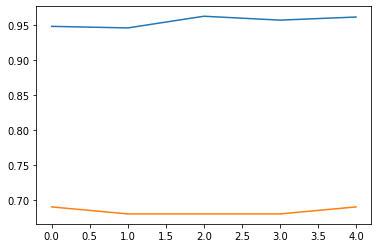

In [ ]:
#Компилируем сеть
model_p3.compile(optimizer=RMSprop(lr=1e-6),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#Обучаем
history = model_p3.fit(X_train,
                    y_train,
                    epochs=5,
                    batch_size=20,
                    validation_data=(X_test, y_test))

#Выводим график точности распознавания на обучающей и проверочной выборках
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.show()

In [ ]:
#Сохранение и загрузка весов
#model_p3.save_weights('/content/drive/My Drive/my_sample_data/Д.З.21/model_p3_weights.h5')
model_p3.load_weights('/content/drive/My Drive/my_sample_data/Д.З.21/model_p3_weights.h5')

**Сохранены веса, дающие точность чуть менее 69% на проверочной выборке**

**Такая точность получена только на данных MFCC. И она лучше чем получалось на исходной модели с усредненными MFCC (при использовании только MFCC там было процентов 60)**

Потенциал модели еще не исчерпан.
Понятно что и модель сырая и учить еще можно/нужно.
Можно и вернуть использование остальных параметров звука.